# Data Structuring and Pruning

In [28]:
# Load datasets

import json
import pathlib

data_path = pathlib.Path('/Users/awagner/Workspace/git/g2p-aggregator/data/local/0.8')
harvested_sources = dict()
for path in data_path.glob('*.json'):
    source = path.parts[-1].split('.')[0]
    with path.open() as json_data:
        # harvested_sources[source] = json.load(json_data) <- this should work, but doesn't due to malformed json
        # what follows is a hack to reassemble into proper JSON object
        associations = list()
        for line in json_data:
            associations.append(json.loads(line))
        
        # resume intended function
        harvested_sources[source] = associations

In [32]:
# Standardize structure and merge files

all_associations = list()
for source in harvested_sources:
    for entry in harvested_sources[source]:
        entry['raw'] = entry.pop(source)
        all_associations.append(entry)
        
len(all_associations)

In [228]:
from collections import Counter

def report_groups(associations):
    groups = Counter()
    for association in associations:
        groups[association['source']] += 1
    total = sum(groups.values())
    for group in sorted(groups):
        print("{}: {} ({:.1f}%)".format(group, groups[group], groups[group] / len(harvested_sources[group]) * 100))
    print("Total: {} ({:.1f}%)".format(total, total / len(all_associations) * 100))

In [229]:
report_groups(all_associations)

brca: 5717 (100.0%)
cgi: 1431 (100.0%)
civic: 3497 (100.0%)
jax: 5754 (100.0%)
molecularmatch: 2079 (100.0%)
oncokb: 4048 (100.0%)
pmkb: 600 (100.0%)
Total: 23126 (100.0%)


In [230]:
# Associations with more than 1 feature
multi_featured = [x for x in all_associations if len(x['features']) > 1]
len(multi_featured) / len(all_associations)

0.0863962639453429

In [231]:
report_groups(multi_featured)

cgi: 140 (9.8%)
jax: 1797 (31.2%)
molecularmatch: 26 (1.3%)
oncokb: 35 (0.9%)
Total: 1998 (8.6%)


In [232]:
# Associations with feature name lists
listed_feature_names = [x for x in all_associations if isinstance(x['feature_names'], list)]
len(listed_feature_names) / len(all_associations)

0.24721093141918188

In [233]:
report_groups(listed_feature_names)

brca: 5717 (100.0%)
Total: 5717 (24.7%)


In [234]:
len([x for x in listed_feature_names if len(x['feature_names']) >1 ])

0

## Feature coordinate filtering

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [235]:
# Associations with coordinate features
coord_featured = list()
no_coord_featured = list()
for association in all_associations:
    c = 0
    for feature in association['features']:
        if ('start' in feature) and ('end') in feature:
            coord_featured.append(association)
            break
        else:
            c+=1
    if c == len(association['features']):
        no_coord_featured.append(association)

In [236]:
report_groups(coord_featured)

brca: 5717 (100.0%)
civic: 3497 (100.0%)
jax: 2499 (43.4%)
molecularmatch: 1664 (80.0%)
oncokb: 1830 (45.2%)
pmkb: 600 (100.0%)
Total: 15807 (68.4%)


In [240]:
report_groups(no_coord_featured)

cgi: 1431 (100.0%)
jax: 3255 (56.6%)
molecularmatch: 415 (20.0%)
oncokb: 2218 (54.8%)
Total: 7319 (31.6%)


In [172]:
# First association has feature, but no end coord

harvested_sources['cgi'][0]['features']

[{'alt': 'C',
  'biomarker_type': 'mutant',
  'chromosome': '9',
  'description': 'ABL1:T315A,F317L,F317V,F317I,F317C,F317I,Y253H,E255K,E255V,F359V,F359C,F359I',
  'geneSymbol': 'ABL1',
  'links': ['http://reg.genome.network/refseq/RS000009',
   'http://reg.genome.network/refseq/RS000057',
   'http://reg.genome.network/refseq/RS000033',
   'http://myvariant.info/v1/variant/chr9:g.133748288T>C?assembly=hg19',
   'http://www.ncbi.nlm.nih.gov/clinvar/variation/376352',
   'http://reg.genome.network/refseq/RS002120',
   'http://reg.genome.network/allele/CA16602794',
   'http://cancer.sanger.ac.uk/cosmic/mutation/overview?id=49074',
   'http://www.ncbi.nlm.nih.gov/clinvar/?term=363231[alleleid]',
   'http://myvariant.info/v1/variant/chr9:g.130872901T>C?assembly=hg38'],
  'name': 'ABL1:F317L',
  'ref': 'T',
  'referenceName': 'GRCh37',
  'start': 133748288,
  'synonyms': ['CM000671.2:g.130872901T>C',
   'NC_000009.10:g.132738109T>C',
   'NC_000009.11:g.133748288T>C',
   'COSM49074',
   'chr9

In [241]:
# Associations with partial coordinate features
partial_coord_featured = list()
no_partial_coord_featured = list()
for association in all_associations:
    c = 0
    for feature in association['features']:
        if ('start' in feature):
            partial_coord_featured.append(association)
            break
        else:
            c+=1
    if c == len(association['features']):
        no_partial_coord_featured.append(association)

In [242]:
report_groups(no_partial_coord_featured)

cgi: 725 (50.7%)
jax: 3255 (56.6%)
molecularmatch: 415 (20.0%)
oncokb: 2218 (54.8%)
Total: 6613 (28.6%)


In [252]:
def get_feature_names(associations):
    return (list(map(lambda x: x['feature_names'], associations)))
feature_names = get_feature_names(no_partial_coord_featured)

In [244]:
no_partial_coord_featured_no_feature_names = [x for x in no_partial_coord_featured if x['feature_names'] is None]
no_partial_coord_featured_with_feature_names = [x for x in no_partial_coord_featured if x['feature_names'] is not None]

In [245]:
report_groups(no_partial_coord_featured_no_feature_names)

molecularmatch: 150 (7.2%)
Total: 150 (0.6%)


In [246]:
# All of these have exactly 1 gene name

len([x['genes'] for x in no_partial_coord_featured_no_feature_names if len(x['genes']) == 1])

150

In [247]:
report_groups(no_partial_coord_featured_with_feature_names)

cgi: 725 (50.7%)
jax: 3255 (56.6%)
molecularmatch: 265 (12.7%)
oncokb: 2218 (54.8%)
Total: 6463 (27.9%)


In [286]:
import re

def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    return(not_found)

amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
remainder = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

cgi: 125 (8.7%)
jax: 533 (9.3%)
molecularmatch: 135 (6.5%)
oncokb: 92 (2.3%)
Total: 885 (3.8%)


In [287]:
fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
r2 = feature_filter(fusion_re, remainder)

cgi: 117 (8.2%)
jax: 554 (9.6%)
molecularmatch: 89 (4.3%)
oncokb: 229 (5.7%)
Total: 989 (4.3%)


In [351]:
ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
r3 = feature_filter(ppm_re, r2)

jax: 460 (8.0%)
molecularmatch: 8 (0.4%)
oncokb: 1350 (33.3%)
Total: 1818 (7.9%)


In [352]:
indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
r4 = feature_filter(indel_re, r3)

jax: 208 (3.6%)
oncokb: 215 (5.3%)
Total: 423 (1.8%)


In [373]:
bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
r5 = feature_filter(bucket_re, r4)

cgi: 183 (12.8%)
jax: 931 (16.2%)
molecularmatch: 8 (0.4%)
Total: 1122 (4.9%)


In [374]:
exon_re = re.compile(r'exon', re.IGNORECASE)
r6 = feature_filter(exon_re, r5)

cgi: 36 (2.5%)
jax: 88 (1.5%)
oncokb: 27 (0.7%)
Total: 151 (0.7%)


In [375]:
expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
r7 = feature_filter(expression_re, r6)

cgi: 172 (12.0%)
jax: 407 (7.1%)
molecularmatch: 1 (0.0%)
oncokb: 226 (5.6%)
Total: 806 (3.5%)


In [377]:
report_groups(r7)

cgi: 92 (6.4%)
jax: 74 (1.3%)
molecularmatch: 24 (1.2%)
oncokb: 79 (2.0%)
Total: 269 (1.2%)


In [378]:
get_feature_names([x for x in r7 if x['source'] == 'cgi'])

['ALK inframe insertion (1151T)',
 'BRAF (V600D,V600K,V600M,V600G,V600R)',
 'DPYD splice donor variant',
 'DPYD splice donor variant',
 'EGFR (S720)',
 'EGFR (L718)',
 'EGFR (L792)',
 'BRAF (V600R)',
 'BRAF (V600E,V600K)',
 'BRAF (V600E,V600D,V600K,V600M,V600G,V600R)',
 'BRAF (V600E,V600K)',
 'DPYD splice donor variant',
 'FGFR2 (V565I,M536I,M538I,I548V,N550,E566G,L618M,K660E)',
 'FGFR2 (M536I,M538I,I548V,N550,E566G,L618M,K660E)',
 'FLT3 (D835)',
 'FLT3 (F691,D835,N676,Y842)',
 'GNAQ (Q209)',
 'GNAQ (Q209)',
 'GNAS (R201)',
 'KIT (D816)',
 'MAP2K1 (P124)',
 'MET kinase domain mutation',
 'TERT promoters core',
 'ESR1 (E380Q,537,538,L536,P535H)',
 'IDH1 (R132)',
 'KIT wildtype',
 'KRAS (G12)',
 'MPL (W515F)',
 'TPMT splice acceptor variant',
 'BRAF (V600)',
 'BRAF (V600E,V600K)',
 'BRAF (V600)',
 'BRAF (V600)',
 'BRAF (V600E,V600D,V600K,V600M,V600G,V600R)',
 'BTK (C481)',
 'CSF3R frameshift variant (D771),frameshift variant (S783)',
 'ERBB2 inframe insertion (A775YVMA),inframe insertion

# Knowledgebase Comparison

## Genes

In [132]:
from collections import defaultdict

def genes_by_source(associations):
    source_genes = defaultdict(set)
    for association in associations:
        source_genes[association['source']].update(association['genes'])
    return source_genes

In [133]:
s = genes_by_source(all_associations)

In [146]:
import pyupset as pyu
import pandas as pd
%matplotlib inline

def plot_overlap(set_dict):
    d = {g: pd.DataFrame(list(set_dict[g])) for g in set_dict}
    pyu.plot(d, inters_size_bounds=(3, 400000))

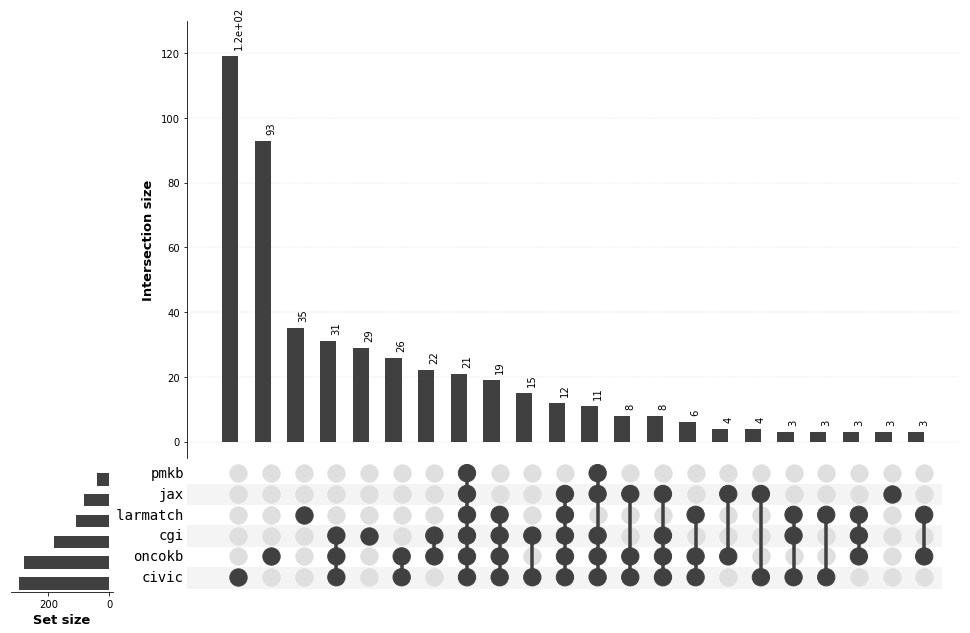

In [147]:
# omitting BRCA (only 2 genes)
s = {k: v for k, v in s.items() if k != 'brca'}
plot_overlap(s)

In [ ]:
# Genes observed in all knowledgebases
